## **Modules**

In [1]:
import argparse
import os
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("./images", exist_ok=True) # this is the directory where your generated images will be saved

ModuleNotFoundError: No module named 'torchvision'

## **Hyper Parameters**

In [ ]:
channels = 1            # number of img channels (MNIST has only 1)
img_size = 32 
n_epochs = 100           # adjust n_epochs to a higher number if you wish
batch_size = 64
lr = 0.002
b1 = 0.5                # adam: decay of first order momentum of gradient
b2 = 0.999              # adam: decay of first order momentum of gradient
latent_dim = 10         # output dim for encoder, input dim for decoder/ discriminator
img_shape = (channels, img_size, img_size)

## **Reparametrization**


Decoder에 들어가기 전, Encoder 아웃풋인 $\mu$(mu)와 $\sigma$(sigma)가 나오게 됩니다. 
$p(z)$에서 샘플링을 할때, 데이터의 확률 분포와 같은 분포에서 샘플을 뽑아야하는데, backpropagation을 하기 위해선, reparametrization의 과정을 거칩니다. 
즉, 정규분포에서 $z$을 샘플링 하는 것이죠. 

더 자세히 들어가면, $\epsilon$을 정규분포 (N(0, 1))에서 샘플링을 하고, 그 값을 분산 $\mu$ exp^(logvar/2)와 곱하고, 평균인 $\mu$를 더해 $z_1$과 $z_2$가 같은 분포를 가지게한다. 



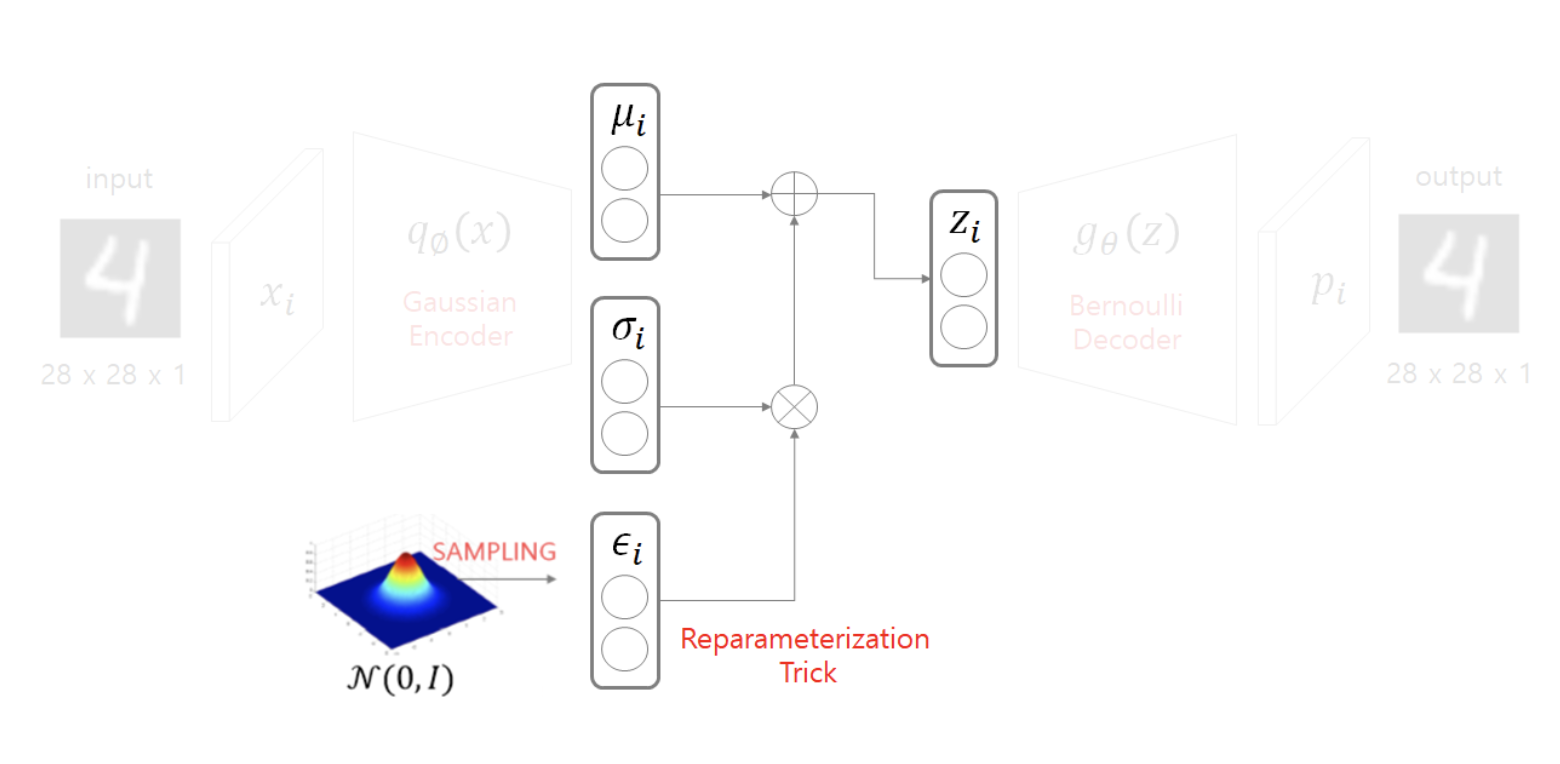

In [ ]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    z = sampled_z * std + mu
    return z

## **Encoder**

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            ### TASK 1: BUILD UP ENCODER ###
            nn.Linear(1024, 512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p=0.2),
            nn.ReLU()
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)

        z = reparameterization(mu, logvar)
        return z

## **Decoder**

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.Tanh(),
        )

    def forward(self, z):
        q = self.model(z)
        q = q.view(q.shape[0], *img_shape)
        return q

## **Discriminator**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            ### TASK 2: BUILD UP Discriminator ###
            nn.Linear(latent_dim, 512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, z):
        x = self.model(z)
        return x

## **Loss Functions & Model Initialization**

In [ ]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialization of three models
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

In [ ]:
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

## **Download MNIST Data**

In [ ]:
os.makedirs("./mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def sample_image(n_row, epoch):
    """Saves a grid of generated digits"""
    # Sample noise
    z = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    gen_imgs = decoder(z)
    save_image(gen_imgs.data, "images/%d.png" % epoch, nrow=n_row, normalize=True)

## **Training**

In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()


    # -----------------------
    #  Save Result Per Epoch
    # -----------------------
    sample_image(n_row=10, epoch=epoch)
    print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, d_loss.item(), g_loss.item()))
            

[Epoch 0/5] [D loss: 0.448283] [G loss: 0.120624]
[Epoch 1/5] [D loss: 0.593648] [G loss: 0.110483]
[Epoch 2/5] [D loss: 0.441235] [G loss: 0.114758]
[Epoch 3/5] [D loss: 0.495010] [G loss: 0.121515]
[Epoch 4/5] [D loss: 0.599811] [G loss: 0.105871]


images 디렉토리 아래에 저장된 이미지들을 보면 아래와 같은 노이즈로부터 차근히 학습되어 생성된 결과를 볼 수 있습니다. 

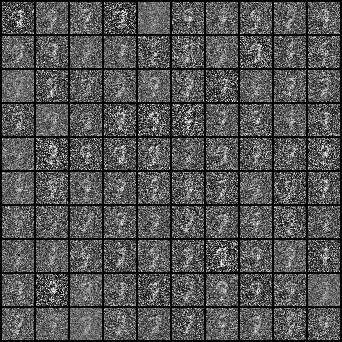

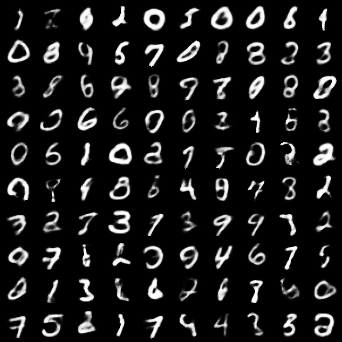